# Hello world 
In this notebook we create the neural network of the sine function. The result is a neural network with an input layer 3 hidden layer and the output layer, capable of calculating the y value of each x value given. 

The trained neural network will be splitted into 2 in order to generate the same inference with the splited neural network runing in 2 separate edge devices (ESP32).

## Mounting drive

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/MyDrive/spiltNN/hello_world_esp32_split/")
!ls

converted_model_noquant.tflite	hello_world_model.h5
converted_model.tflite		hello_world_split1.ipynb
esp_split1			hello_world_split2.ipynb
esp_split2			models
hello_world_full_NN.ipynb	output_split.pickle
hello_world_joined_split.ipynb	x_test.pickle


In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# Generating data


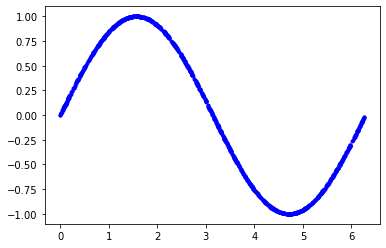

In [4]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

## Add noise

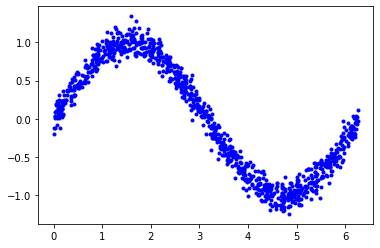

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

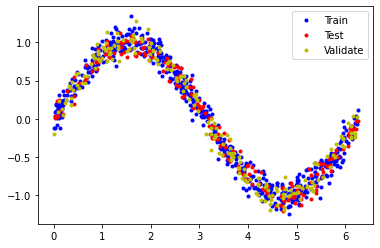

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

# Create model schema

In [7]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu',name="first_layer", input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu',name="second_layer"))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1,name="output_layer"))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])


In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

model.save("hello_world_model.h5")

Epoch 1/500
10/10 [==============================] - 1s 22ms/step - loss: 0.6834 - mae: 0.7333 - val_loss: 0.5412 - val_mae: 0.6609
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4666 - mae: 0.6007 - val_loss: 0.4645 - val_mae: 0.5874
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4398 - mae: 0.5616 - val_loss: 0.4478 - val_mae: 0.5724
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4226 - mae: 0.5469 - val_loss: 0.4266 - val_mae: 0.5610
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4011 - mae: 0.5373 - val_loss: 0.4085 - val_mae: 0.5519
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3841 - mae: 0.5304 - val_loss: 0.3925 - val_mae: 0.5430
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3680 - mae: 0.5197 - val_loss: 0.3759 - val_mae: 0.5318
Epoch 8/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3520 - 

In [ ]:
model.weights

[<tf.Variable 'first_layer/kernel:0' shape=(1, 16) dtype=float32, numpy=
 array([[-0.39788383,  0.46116257,  0.37156865, -0.07777083, -0.2472133 ,
          0.1315595 ,  0.6120838 , -0.07711333,  0.3081392 ,  0.09540156,
          0.06901786,  0.14382397,  0.50789785,  0.18803696, -0.00574451,
         -0.5632218 ]], dtype=float32)>,
 <tf.Variable 'first_layer/bias:0' shape=(16,) dtype=float32, numpy=
 array([ 0.        ,  0.47112456, -1.0349376 ,  0.        ,  0.        ,
         0.01800696, -0.6069823 ,  0.        , -0.4051201 ,  0.33553302,
         0.78297174,  0.1324779 ,  0.0838714 , -0.15206404,  0.37058446,
         0.        ], dtype=float32)>,
 <tf.Variable 'second_layer/kernel:0' shape=(16, 16) dtype=float32, numpy=
 array([[ 0.00875294, -0.04890293, -0.07921267,  0.42651084,  0.1633878 ,
         -0.13349813, -0.05536762,  0.0875214 , -0.03756449,  0.21884283,
         -0.27020234,  0.04222476,  0.04236186,  0.04289168, -0.19061677,
         -0.33865362],
        [ 0.10046

### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0865
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

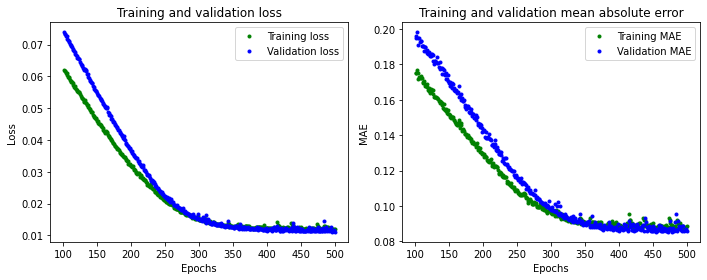

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Great results! From these graphs, we can see several exciting things:

*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 [==============================] - 0s 2ms/step - loss: 0.0107 - mae: 0.0832


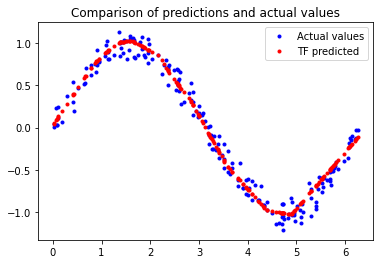

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

x= 0.0, y= 0.029318124055862427
x= 0.314159265359, y= 0.3005623519420624
x= 0.628318530718, y= 0.5718064308166504
x= 0.942477796077, y= 0.8100959062576294
x= 1.256637061436, y= 0.970966100692749
x= 1.570796326795, y= 1.023716688156128
x= 1.884955592154, y= 0.9402663707733154
x= 2.199114857513, y= 0.8380614519119263
x= 2.513274122872, y= 0.5460314750671387
x= 2.8274333882310003, y= 0.31125566363334656
x= 3.14159265359, y= -0.011488735675811768
x= 3.4557519189490002, y= -0.3342333137989044
x= 3.769911184308, y= -0.5813242793083191
x= 4.084070449667, y= -0.7852424383163452
x= 4.398229715026, y= -0.9719376564025879
x= 4.7123889803850005, y= -1.0083835124969482
x= 5.026548245744, y= -0.9365911483764648
x= 5.340707511103, y= -0.7264589071273804
x= 5.654866776462001, y= -0.516325831413269
x= 5.9690260418209995, y= -0.30619335174560547
x= 6.28318530718, y= -0.0960603803396225


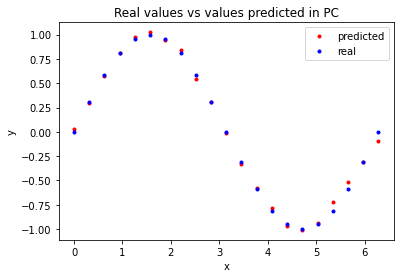

0.036581953794891535


In [ ]:
inference_count=0
kInferencesPerCycle = 20
kXrange = 2* 3.14159265359
x_list=[]
y_list=[]
position=inference_count/kInferencesPerCycle
x_val=position*kXrange
while inference_count <= kInferencesPerCycle:
  position=inference_count/kInferencesPerCycle
  x_val=np.array([[position*kXrange]])
  y_val=model.predict_on_batch(x_val)
  inference_count+=1
  print(f"x= {x_val[0][0]}, y= {y_val[0][0]}")
  x_list.append(x_val[0][0])
  y_list.append(y_val[0][0])
plt.plot(x_list,y_list, "r.",label="predicted")
y_real=np.sin(x_list)
plt.plot(x_list,y_real,"b.",label="real")
plt.legend()
plt.title("Real values vs values predicted in PC")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(np.sqrt(np.mean((y_real-y_list)**2)))

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is *knowing when to stop*. This model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.

## Generate a TensorFlow Lite Model

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open("converted_model_noquant.tflite", "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
#open("esp_split1/converted_model_split1.tflite", "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpp2o8xt6v/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6c5_z_5/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6c5_z_5/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
